In [1]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
from PIL import Image

In [2]:
# 1. Проверка доступности flash_attention_2
try:
    from flash_attn import flash_attn_func
    attn_implementation = "flash_attention_2"
except ImportError:
    print("Flash Attention 2 не установлен. Используем стандартную реализацию внимания.")
    attn_implementation = "eager"  # Стандартная реализация, если flash_attention_2 недоступен

In [3]:
# 2. Загрузка модели с рекомендованными параметрами
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct",
    torch_dtype=torch.bfloat16,  # Используем bfloat16 для экономии памяти
    attn_implementation=attn_implementation,  # Используем flash_attention_2, если доступно
    device_map="auto"  # Автоматическое распределение по устройствам
)

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
# 3. Загрузка процессора
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
# 4. Подготовка сообщения с изображением и вопросом
image_path = "pulp_fiction.jpg"

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,  # Путь к локальному изображению
            },
            {
                "type": "text",
                "text": "Analyze the image for any prohibited content such as violence, weapons, blood, or similar elements. Answer the following: 1. Is there prohibited content in the image? 2. If yes, provide details about what is found."
            },
        ],
    }
]

In [6]:
# 5. Подготовка данных для модели
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")  # Если есть GPU, иначе убрать строку

In [7]:
# 6. Генерация ответа
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

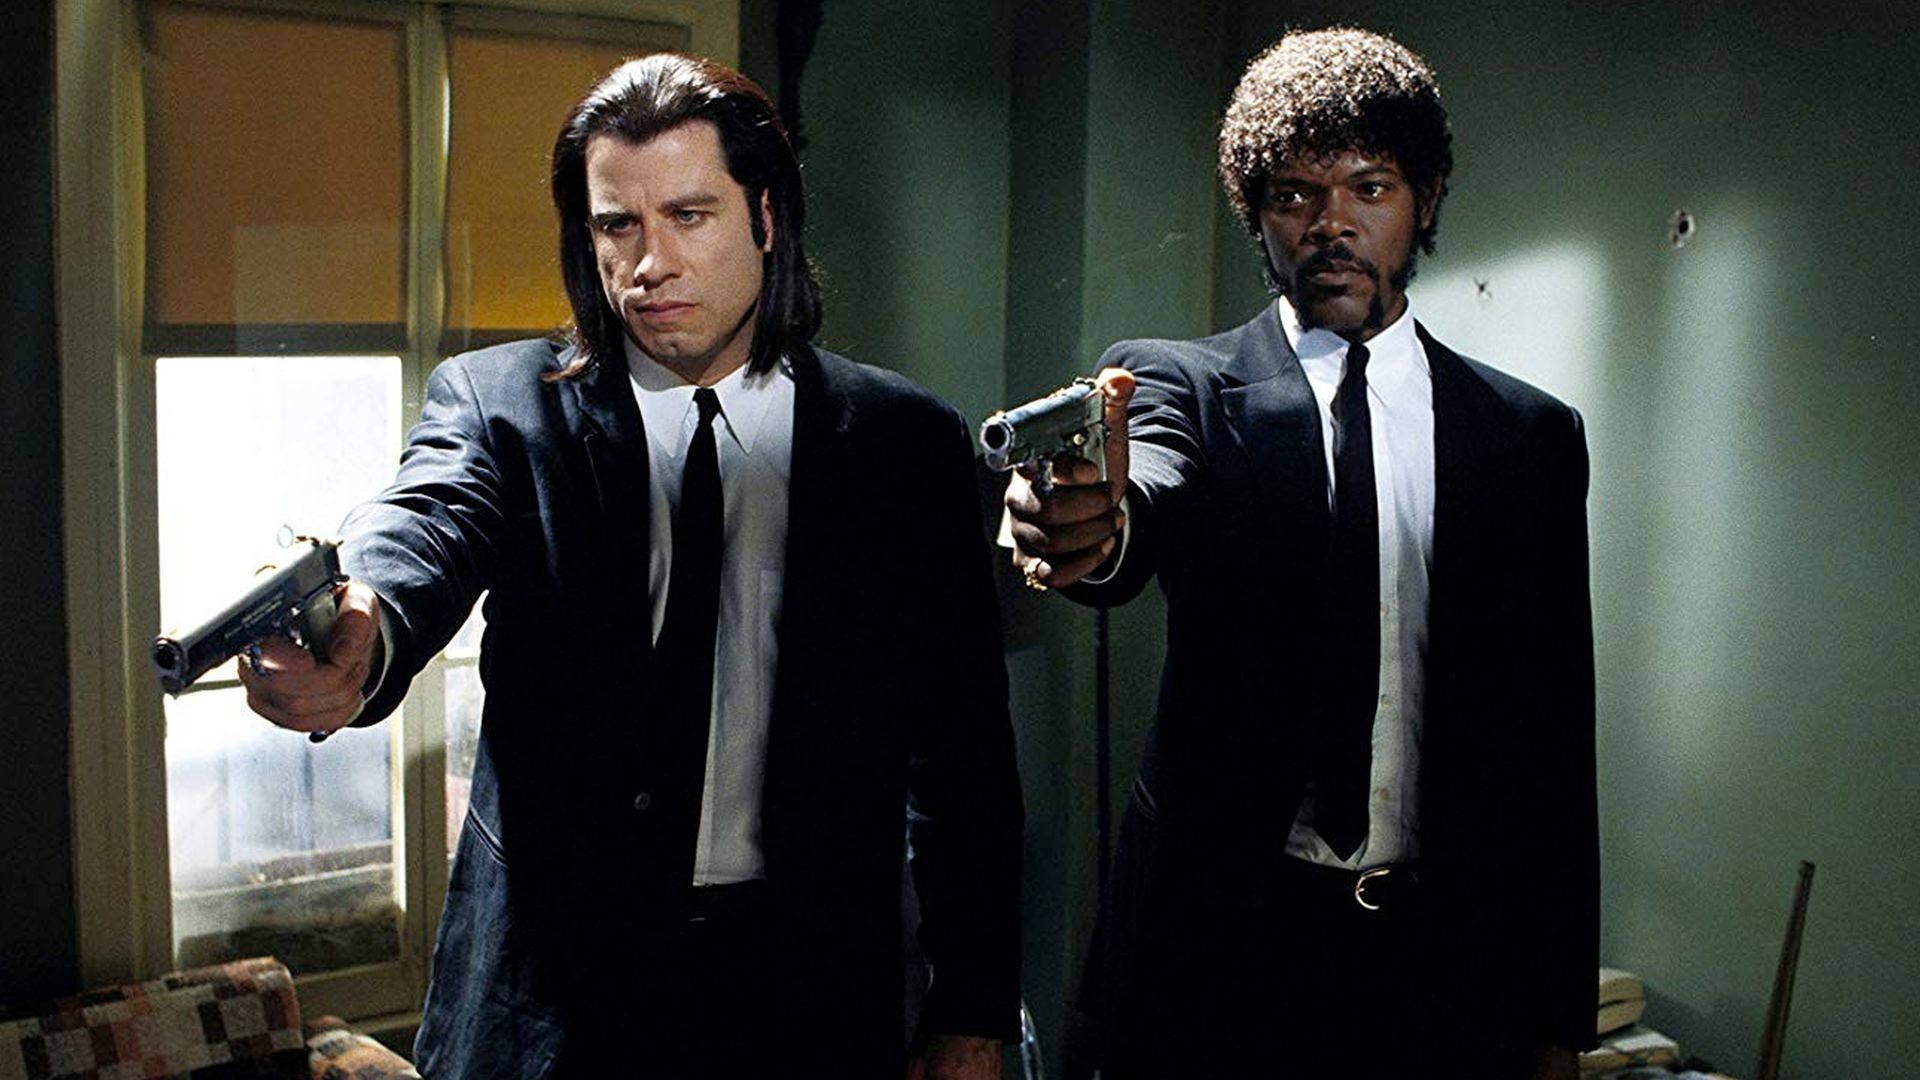

In [8]:
# 8. Изображение для анализа
image = Image.open(image_path).convert("RGB")
image

In [9]:
# 9. Вывод результата анализа
print("Результат анализа:")
print(output_text[0])

Результат анализа:
1. Yes, there is prohibited content in the image.
2. The image depicts two individuals holding firearms, which are considered weapons. This scene is from the movie "Pulp Fiction," and while it is part of the film's narrative, it represents a violent act. However, it is important to note that this is a fictional representation and not real violence.
